In [1]:
from gym import Env, spaces
import numpy as np
import random
import pandas as pd
from sklearn import preprocessing
import os    
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import torch
import keras

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython: from IPython import display

# Environment

In [2]:
class FXEnv_4opt(Env):
    #--------------------------------------------------------------------------------
    # Initilization
    #--------------------------------------------------------------------------------
    def __init__(self, df):
        self.balance = INITIAL_ACCOUNT_BALANCE
        
        self.holding = False
        self.PL = 0
        self.action_type = 0
        self.df = df
        self.reward_range = (0, MAX_ACCOUNT_BALANCE) 
        
        # initializes the starting location in the data to a valid random location
        self.current_step = random.randint(obSpaceDim2-1, len(df)-(MAX_STEPS+1)) 
        
        # actions we can take: action(0 = sell, 1 = wait, 2 = long, 3 = short)
        self.action_space = spaces.Discrete(4)
        
        # observable environment. This is the designated shape the model can observe. 
        self.observation_space = spaces.Box(low=0, high=1, shape=(obSpaceDim2, obSpaceDim1))
    
    #--------------------------------------------------------------------------------
    # Performs 1 step
    #--------------------------------------------------------------------------------
    def step(self, action):
        
        # stop loss
        # if loss is higher then 5% of total balance, set the action to sell
#         if self.PL <= self.balance*-0.05:
#             action = 0     #sell order
            
        self.profitLoss() # Updates values for current price, losses, and gains
        self.sold = 0 # initializes the sale gained from turn to 0 before an action is made
        self._take_action(action) # Execute one time step within the environment
        self.current_step += 1
        self.epLength += 1
        if self.epLength >= MAX_STEPS: self.done = True
        
        
        reward = 0 # initilizes reward at 0. This will stay the same if the  proffit/loss = 0
        if self.stepPL > 0: reward = 1 + self.sold # if the model has made money in that step, +1. If the model has also sold assets that turn, also +/- that proffit/loss.
        elif self.stepPL < 0: reward = -1 + self.sold # if the model has lost money in that step, -1. If the model has also sold assets that turn, also +/- that proffit/loss.
            
        obs = self._next_observation() # gets the next observation
        return obs, reward, self.done, {}
    
    #--------------------------------------------------------------------------------
    # Calculate profit / loss
    #--------------------------------------------------------------------------------
    def profitLoss(self):
        
        # sets the previous price to a variable (refrencePrice) before the current price is calculated
        if self.long == True: self.refrencePrice=self.longPrice
        elif self.long == False: self.refrencePrice=self.shortPrice
        
        # Set the current price to a random price within the open/close range
        currentPrice = random.uniform(
            self.df.loc[self.current_step, "Open"],
            self.df.loc[self.current_step, "Close"])
        
        # in the real world the long price and short price would be slightly diffrent. This can be updated to reflect this.
        self.longPrice = currentPrice 
        self.shortPrice = currentPrice
        
        # calculates the profit/loss for the step
        if self.holding == True:
            # if in a long trade...
            if self.long == True:
                self.stepPL = (currentPrice-self.refrencePrice) * self.holding_amount
                self.PL = (currentPrice-self.buyPrice) * self.holding_amount
            
            # if in a short trade...
            elif self.long == False:
                self.stepPL = (currentPrice-self.refrencePrice) * -self.holding_amount
                self.PL = (currentPrice-self.buyPrice) * -self.holding_amount
        
        # if not in a trade no profit/loss was made
        else:
            self.PL = 0
            self.stepPL = 0
    
    #--------------------------------------------------------------------------------
    # Specifics of the actions that can be performed in each step
    #--------------------------------------------------------------------------------
    def _take_action(self, action):
        self.action_type = action
        
        # calculates the maximum number of units that can be purchased given the current account balance
        margin_multiplier = 0.02
        margin_avail = self.balance
        self.units_avalable = margin_avail/margin_multiplier
        
        # sets the quantity that can be purchased to 20% of the maxumum units avalable given the balance
        amount = int(self.units_avalable * 0.2)      
        
        # Sell block
        if self.action_type == 0:
            if self.holding == False: pass
            elif self.holding == True:
                self.realizedPL += self.PL
                self.sold = self.PL
                self.balance = INITIAL_ACCOUNT_BALANCE + self.realizedPL
                self.holding_amount = 0
                self.holding = False
                self.done = True # concludes the episode
                
        # Wait block (Do nothing)        
        elif self.action_type == 1:
            pass
        
        # Long Order Block
        elif self.action_type == 2:
            if self.holding == True: pass
            elif self.holding == False:
                self.buyPrice = self.longPrice
                self.holding_amount = amount
                self.holding = True
                self.long = True
                
        # Short Order Block
        elif self.action_type == 3:
            if self.holding == True: pass
            elif self.holding == False:
                self.buyPrice = self.shortPrice
                self.holding_amount = amount
                self.holding = True
                self.long = False        
    
    #--------------------------------------------------------------------------------
    # Resets the environment
    #--------------------------------------------------------------------------------
    def reset(self):
        # Reset the state of the environment to an initial state
        self.epLength = 0
        self.balance = INITIAL_ACCOUNT_BALANCE
        self.holding_amount = 0
        self.holding = False
        self.realizedPL = 0
        self.PL = 0
        self.stepPL = 0
        self.long = True
        self.longPrice = 0
        self.shortPrice = 0
        self.done = False

        # Set the current step to a random point within the data frame
        self.current_step = random.randint(obSpaceDim2-1, len(df)-(MAX_STEPS+1))
        return self._next_observation()
    
    #--------------------------------------------------------------------------------
    # Grabs the next frame worth of data consiting of a given number of rows of data (obSpaceDim2)
    #--------------------------------------------------------------------------------
    def _next_observation(self):
        obs = self.df.loc[self.current_step-(obSpaceDim2-1): self.current_step].values
        return obs
    
    #--------------------------------------------------------------------------------
    # Renders a graph durring training
    #--------------------------------------------------------------------------------
    def render(self, mode='human', close=False):
        if self.done:
            profit.append(self.realizedPL)
            plot(profit, 100) # plot to screen

# Visualization Plot

In [3]:
# plots the profit of each episode and 100 episode moving average 
def plot(values, moving_avg_period):
    plt.figure(2)
    plt.clf()
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Profit')
    plt.plot(values)
    plt.plot(np.zeros(len(values)), color = 'black')
    
    moving_avg = get_moving_average(moving_avg_period, values)
    plt.plot(moving_avg)
    plt.pause(0.001)
    print("Episode ", len(values), '\n', moving_avg_period, 'episode moving avg: ', moving_avg[-1])
    if is_ipython: display.clear_output(wait=True)
        
def get_moving_average(period, values):
    values = torch.tensor(values, dtype=torch.float)
    if len (values) >= period:
        moving_avg = values.unfold(dimension = 0, size = period, step = 1) .mean(dim=1) .flatten(start_dim=0)
        moving_avg = torch.cat((torch.zeros(period-1), moving_avg))
        return moving_avg.numpy()
    else:
        moving_avg = torch.zeros(len(values))
        return moving_avg.numpy()

# Data Setup

In [4]:
df = pd.read_csv('data/EUR_USD_H1.csv') # reads in real data
df = pd.read_csv('data/sineWave_dummyData.csv') # reads in dummy data

# sets the dimensions of observation space
obSpaceDim1 = df.shape[1] # columns in df
obSpaceDim2 = 10 # number of rows the model should see at once

MAX_ACCOUNT_BALANCE = 1000000
INITIAL_ACCOUNT_BALANCE = 5000
MAX_STEPS = 200
WINDOW_LENGTH = 1

env = FXEnv_4opt(df)

# Test Environment

In [5]:
episodes = 10
for episode in range(episodes):
    env.reset()
    done = False
    score = 0
    
    while not done:
        #env.render()
        action = env.action_space.sample()
        obs, reward, done, extra = env.step(action)
        score += reward
    print("Epesode: {} Score: {}".format(episode+1, score))

Epesode: 1 Score: -50.33197868129302
Epesode: 2 Score: 282.8184450317118
Epesode: 3 Score: -0.07330468606570051
Epesode: 4 Score: 32.28718108680317
Epesode: 5 Score: 10.362437143500824
Epesode: 6 Score: -6.202679066562688
Epesode: 7 Score: -6.617260589008133
Epesode: 8 Score: 34.37458000024951
Epesode: 9 Score: -27.171620499548798
Epesode: 10 Score: 11.216795014643786


# Keras Imports

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv1D, Conv2D, LSTM, Dropout
from tensorflow.keras.optimizers import Adam

from rl.agents.dqn import DQNAgent
from rl.agents.cem import CEMAgent

from rl.policy import BoltzmannQPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory, EpisodeParameterMemory

# Neural Network

In [7]:
nb_actions = env.action_space.n

### Dense Neural Network

In [8]:
DNNmodel = Sequential()
DNNmodel.add(Flatten(input_shape=(WINDOW_LENGTH,) + env.observation_space.shape))
DNNmodel.add(Dense(64, activation='relu'))
DNNmodel.add(Dense(32, activation='relu'))
DNNmodel.add(Dense(16, activation='relu'))
DNNmodel.add(Dense(nb_actions, activation='linear'))
print(DNNmodel.summary())
keras.utils.plot_model(DNNmodel, "DNNmodel.png", show_shapes=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                3264      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 68        
Total params: 5,940
Trainable params: 5,940
Non-trainable params: 0
_________________________________________________________________
None
('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/),

### 1D Convolutional Neural Network

In [9]:
CNNmodel = Sequential()
CNNmodel.add(Conv1D(filters=32,kernel_size=3, activation='relu', input_shape=(1,) + env.observation_space.shape))
CNNmodel.add(Dense(units =32, activation='relu'))
CNNmodel.add(Flatten())
CNNmodel.add(Dense(units=nb_actions))
print(CNNmodel.summary())
keras.utils.plot_model(CNNmodel, "CNNmodel.png", show_shapes=True)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1, 8, 32)          512       
_________________________________________________________________
dense_4 (Dense)              (None, 1, 8, 32)          1056      
_________________________________________________________________
flatten_1 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 1028      
Total params: 2,596
Trainable params: 2,596
Non-trainable params: 0
_________________________________________________________________
None
('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


### 2D Convolutional Neural Network

In [10]:
CNNmodel2 = Sequential()
CNNmodel2.add(Conv2D(64, 1, strides=(6, 6),padding="valid", activation='relu', input_shape=(1,) + env.observation_space.shape))
CNNmodel2.add(Conv2D(64, 1, strides=(3, 3),padding="valid", activation="relu"))
CNNmodel2.add(Conv2D(64, 1, strides=(1, 1),padding="valid", activation="relu"))
CNNmodel2.add(Flatten())
CNNmodel2.add(Dense(512, activation="relu"))
CNNmodel2.add(Dense(256, activation="relu"))
CNNmodel2.add(Dense(64, activation="relu"))
CNNmodel2.add(Dense(units=nb_actions, activation='linear'))
print(CNNmodel2.summary())
keras.utils.plot_model(CNNmodel2, "CNNmodel2.png", show_shapes=True)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 1, 2, 64)          384       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 1, 64)          4160      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 1, 64)          4160      
_________________________________________________________________
flatten_2 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               33280     
_________________________________________________________________
dense_7 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_8 (Dense)              (None, 64)               

### LSTM

In [11]:
LSTMmodel = Sequential()
LSTMmodel.add(LSTM(64, input_shape=env.observation_space.shape, return_sequences=True))
LSTMmodel.add(LSTM(64, return_sequences = True))
LSTMmodel.add(LSTM(64))
LSTMmodel.add(Dropout(0.2))
LSTMmodel.add(Dense(32))
LSTMmodel.add(Activation('relu'))
LSTMmodel.add(Dense(nb_actions))
LSTMmodel.add(Activation('linear'))
print(LSTMmodel.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 64)            17920     
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 64)            33024     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 32)                2080      
_________________________________________________________________
activation (Activation)      (None, 32)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 4)                

In [12]:
# acts as a coupling mechanism between the agent and the environment
# Given a state batch, This removes the second dimension
# Needed for LSTM
from rl.core import Processor
class CustomProcessor(Processor):
    def process_state_batch(self, batch):
        return np.squeeze(batch, axis=1)

processor = CustomProcessor()

# DQN

In [13]:
memory = SequentialMemory(limit=50000, window_length=WINDOW_LENGTH)
policy = EpsGreedyQPolicy()
dqn = DQNAgent(model=DNNmodel, nb_actions=nb_actions, memory=memory, nb_steps_warmup=200,
               target_model_update=1e-2, policy=policy, enable_dueling_network=False, dueling_type='avg')
dqn.compile(Adam(lr=1e-3), metrics=['mae']) 

In [14]:
# '''
# LSTM DQN
# '''
# memory = SequentialMemory(limit=50000, window_length=1)
# policy = BoltzmannQPolicy()
# dqn = DQNAgent(model=LSTMmodel, nb_actions=nb_actions, memory=memory, nb_steps_warmup=500,
# target_model_update=1e-2, policy=policy, processor = processor)
# dqn.compile(Adam(lr=1e-4), metrics=['mae'])

 49918/50000: episode: 1374, duration: 0.356s, episode steps:  22, steps per second:  62, episode reward: -45.878, mean reward: -2.085 [-46.878,  1.000], mean action: 1.455 [0.000, 3.000],  loss: 592.450989, mae: 45.832180, mean_q: 76.175003
done, took 446.985 seconds
Done!


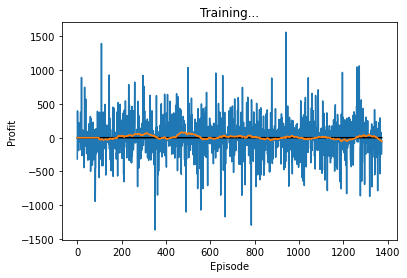

Episode  1374 
 100 episode moving avg:  -56.954117


In [15]:
profit=[]
history = dqn.fit(env, nb_steps=50000, visualize=True, verbose=2)
print('Done!')
plot(profit, 100)

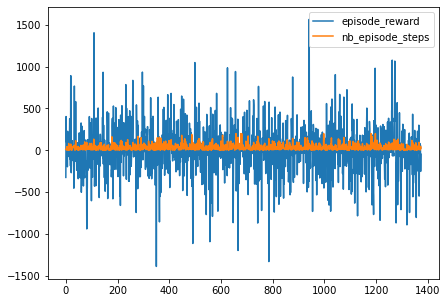

In [16]:
pd.DataFrame(history.history)[["episode_reward", "nb_episode_steps"]].plot(figsize=(7,5));

In [17]:
# After training is done, we save the final weights.
dqn.save_weights('saves/dqn_FXenv_weights.h5f', overwrite=True)
print('saved')

saved


In [18]:
# Finally, evaluate our algorithm for 5 episodes.
dqn.test(env, nb_episodes=5, visualize=False)

Testing for 5 episodes ...
Episode 1: reward: 370.849, steps: 113
Episode 2: reward: 19.000, steps: 200
Episode 3: reward: 407.028, steps: 49
Episode 4: reward: -263.458, steps: 166
Episode 5: reward: -102.845, steps: 90
